In [1]:
import importlib
import numpy as np
import HelperFunctions
importlib.reload(HelperFunctions)
quarters = 8
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
import os
from sklearn.preprocessing import PolynomialFeatures
import pickle

# Getting Stock Data

In [2]:
base = HelperFunctions.getStockData()
mainStockFrame = base
GDPs = HelperFunctions.getGDPdict()
mainStockFrame = HelperFunctions.combine(mainStockFrame, GDPs)
mainStockFrame = HelperFunctions.addBondRates(mainStockFrame)



In [3]:
mainStockFrame = HelperFunctions.reformat(mainStockFrame, quarters)

In [4]:
mainStockFrame = HelperFunctions.addPriceChange(mainStockFrame, quarters)

In [5]:
mainStockFrame = HelperFunctions.addEarningsGrowth(mainStockFrame, quarters)

In [6]:
mainStockFrame.shape

(2631, 420)

100 models trained with random train test splits

In [7]:
import warnings
warnings.filterwarnings('ignore')
resultsListRF=[]
resultsListClf=[]
resultsListLog=[]

rfs = []
logs = []
clfs = []

runs = pickle.load(open('model_runs.p','rb'))

rfs = runs[0]
logs = runs[1]
clfs = runs[2]

for i in range(100):
    print(i)
    try:
        
        X_train, X_test, y_train, y_test, train_indices, test_indices, df = HelperFunctions.train_test(mainStockFrame, i, quarters)
        '''
        rf = RandomForestClassifier(n_estimators=291, max_depth=46, random_state=0, n_jobs = -1).fit(X_train, y_train["Actual"])
        log = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train["Actual"])
        clf = LinearDiscriminantAnalysis().fit(X_train, y_train["Actual"])

        rfs.append(rf)
        logs.append(log)
        clfs.append(clf)
        '''
        resultsRF = HelperFunctions.getResults(mainStockFrame, X_train, X_test, y_train, y_test, rfs[i], sklearn.metrics.accuracy_score, test_indices, quarters)
        resultsLog = HelperFunctions.getResults(mainStockFrame, X_train, X_test, y_train, y_test, logs[i], sklearn.metrics.accuracy_score, test_indices,quarters)
        resultsClf = HelperFunctions.getResults(mainStockFrame, X_train, X_test, y_train, y_test, clfs[i], sklearn.metrics.accuracy_score, test_indices,quarters)
        
        resultsListRF.append(resultsRF)
        resultsListClf.append(resultsClf)
        resultsListLog.append(resultsLog)
            
    except Exception as e:
        print(e)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [8]:
'''
model_runs = [rfs,logs,clfs]
pickle.dump(model_runs,open('model_runs.p','wb'))
'''

"\nmodel_runs = [rfs,logs,clfs]\npickle.dump(model_runs,open('model_runs.p','wb'))\n"

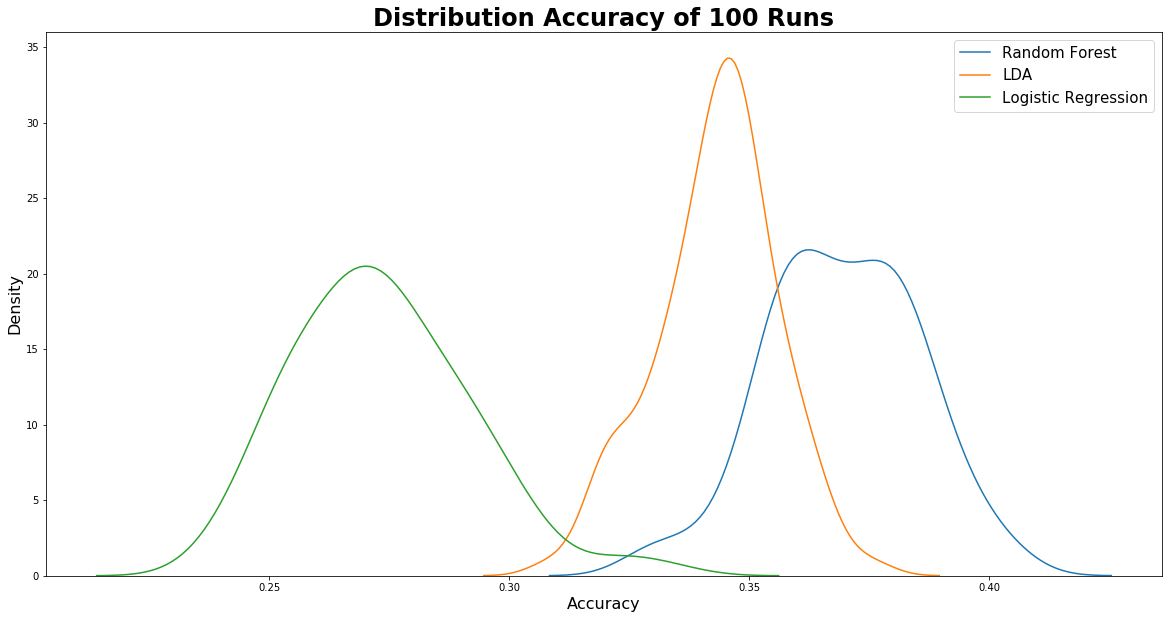

In [21]:
sns.kdeplot([i[1] for i in resultsListRF], label = "Random Forest")
sns.kdeplot([i[1] for i in resultsListClf], label="LDA")
sns.kdeplot([i[1] for i in resultsListLog], label="Logistic Regression")

plt.xlabel("Accuracy", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.title("Distribution Accuracy of 100 Runs", fontsize=24, weight = 'bold')
plt.legend(prop={'size': 15})

Model's trained with data up to year i

1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


Text(0.5,1,'Accuracy vs Time Period')

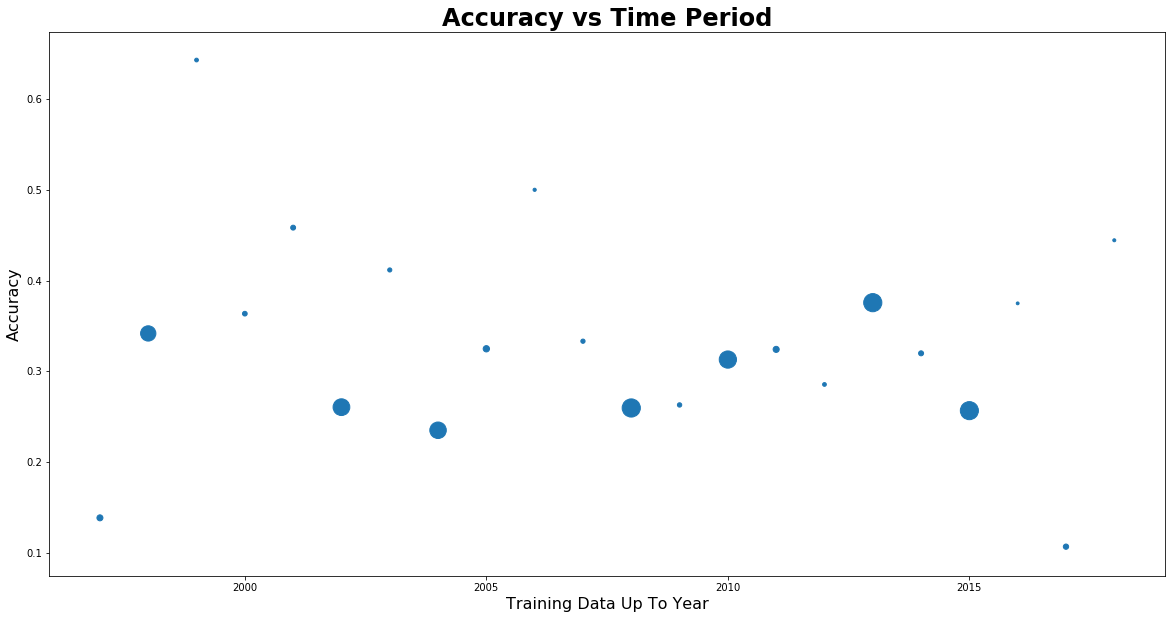

In [26]:
import warnings
warnings.filterwarnings('ignore')
resultsListRFYears=[]
rfs = []
rfs = pickle.load(open('model_runs_yearly.p','rb'))



for i in range(1997, 2019):
    print(i)
    try:
        X_train, X_test, y_train, y_test, train_indices, test_indices, df = HelperFunctions.train_test(mainStockFrame, 1, quarters, i)
        #rf = RandomForestClassifier(n_estimators=291, max_depth=46, random_state=0, n_jobs = -1).fit(X_train, y_train["Actual"])
        rf = rfs[i - 1997]
        resultsRF = HelperFunctions.getResults(mainStockFrame, X_train, X_test, y_train, y_test, rf, sklearn.metrics.accuracy_score, test_indices, quarters)
        resultsListRFYears.append((i, resultsRF, y_test.shape[0]))
        #rfs.append(rf)
            
    except Exception as e:
        print(e)
        
#pickle.dump(rfs,open('model_runs_yearly.p','wb'))
        
plt.scatter([i[0] for i in resultsListRFYears], [i[1][1] for i in resultsListRFYears], s = [i[2] for i in resultsListRFYears])
plt.xlabel("Training Data Up To Year", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.title("Accuracy vs Time Period", fontsize=24, weight = 'bold')


In [11]:
'''
#No need to run this unless you wanna do a gridsearch again :)
X_train, X_test, y_train, y_test, train_indices, test_indices, df = HelperFunctions.train_test(mainStockFrame, i, quarters)

rf = RandomForestClassifier()
params = {'max_depth':list(range(1,100,5)),'n_estimators':list(range(1,300, 10))}
rf_grid = GridSearchCV(rf,params,cv=5, verbose = 1,n_jobs = -1)

x = pd.concat([X_train, X_test])
y = y_train["Actual"].tolist()
y.extend(y_test["Actual"].tolist())
rf_grid.fit(x,y)
rf_grid.cv_results_
'''

'\n#No need to run this unless you wanna do a gridsearch again :)\nX_train, X_test, y_train, y_test, train_indices, test_indices, df = HelperFunctions.train_test(mainStockFrame, i, quarters)\n\nrf = RandomForestClassifier()\nparams = {\'max_depth\':list(range(1,100,5)),\'n_estimators\':list(range(1,300, 10))}\nrf_grid = GridSearchCV(rf,params,cv=5, verbose = 1,n_jobs = -1)\n\nx = pd.concat([X_train, X_test])\ny = y_train["Actual"].tolist()\ny.extend(y_test["Actual"].tolist())\nrf_grid.fit(x,y)\nrf_grid.cv_results_\n'

In [12]:
#rf_grid.cv_results_["params"][rf_grid.cv_results_['mean_test_score'].tolist().index(max(rf_grid.cv_results_['mean_test_score']))]


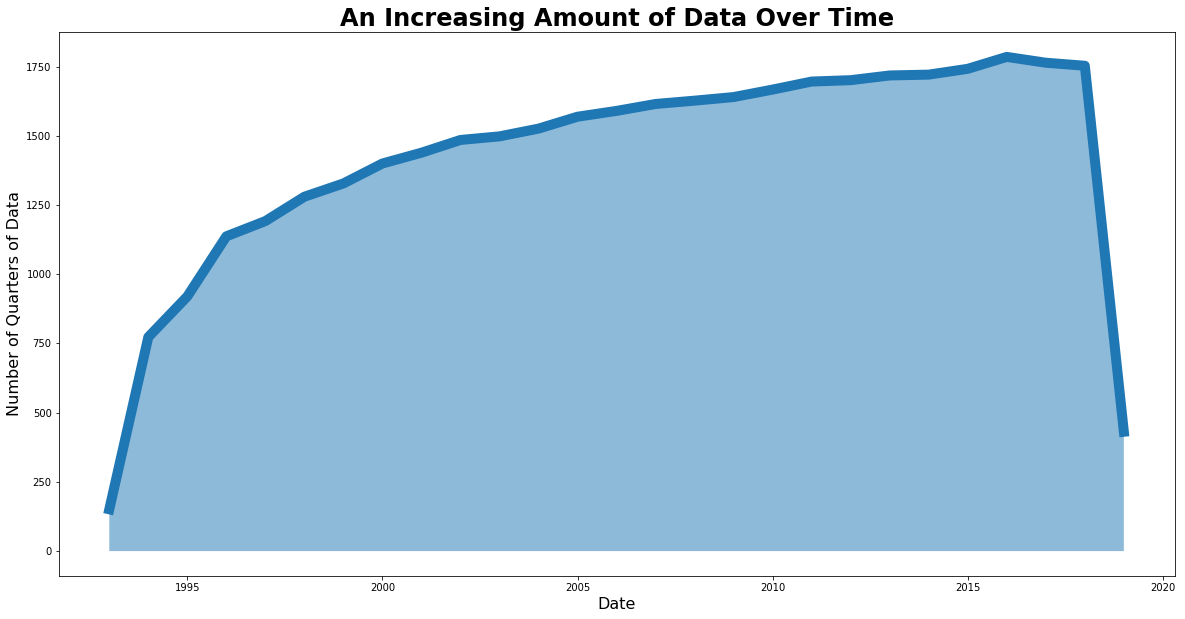

In [19]:
base['Date'] = pd.to_datetime(base['Quarter end'])
# print(base["Date"].groupby(base["Date"].dt.year).count().values)
#print(np.unique(base["Date"].dt.year.values))
# print(base["Date"].groupby(base["Date"].dt.year).count())
ax = base["Date"].groupby(base["Date"].dt.year).count().plot(kind="line", linewidth = 10)
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Number of Quarters of Data", fontsize=16)
ax.set_title("An Increasing Amount of Data Over Time", fontsize=24, weight = 'bold')
plt.fill_between(np.unique(base["Date"].dt.year.values),base["Date"].groupby(base["Date"].dt.year).count().values,alpha=0.5)

In [14]:
mainStockFrame.columns

Index(['Unnamed: 08', 'Asset turnover8', 'Assets8',
       'Book value of equity per share8', 'Capital expenditures8',
       'Cash at end of period8', 'Cash change during period8',
       'Cash from financing activities8', 'Cash from investing activities8',
       'Cash from operating activities8',
       ...
       'PriceChange3/4', 'PriceChange4/5', 'PriceChange5/6', 'PriceChange6/7',
       'PriceChange7/8', 'PriceChange4/8', 'EarningsGrowth5/1',
       'EarningsGrowth6/2', 'EarningsGrowth7/3', 'EarningsGrowth8/4'],
      dtype='object', length=420)

[2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016]


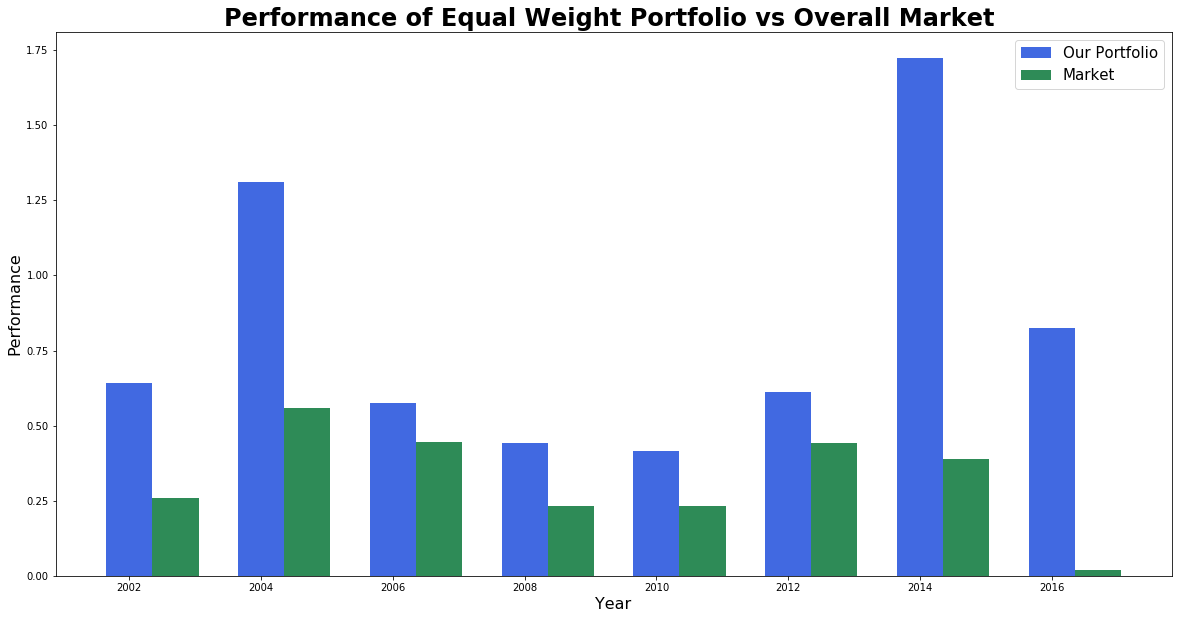

In [27]:
ours = []
sp = []
years = []
for i in resultsListRFYears:
    if i[0] %2 == 0 and i[0] > 2000 and i[0] < 2018:
        years.append(i[0])
        ours.append(HelperFunctions.play(i[1][0], .4,.3, quarters)[0])
        sp.append(HelperFunctions.play(i[1][0], .4,.3, quarters)[1])

N = len(ours)
print(years)

ind = np.arange(N)  # the x locations for the groups
width =0.35       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, ours, width, color='royalblue', label = "Our Portfolio")
rects2 = ax.bar(ind+width, sp, width, color='seagreen', label = "Market")
ax.set_xticklabels(years)
ax.set_xticks(ind) 
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Performance", fontsize=16)
ax.set_title("Performance of Equal Weight Portfolio vs Overall Market ", fontsize=24, weight = 'bold')
plt.legend(prop={'size': 15})


plt.show()

In [30]:
prec = [[],[],[],[]]
years = []
for i in resultsListRFYears:
    # print(i[0])
    # print(HelperFunctions.accuracy_by_class(i[1][0]))
    years.append(i[0])
    for j in range(4):
        prec[j].append(HelperFunctions.accuracy_by_class(i[1][0])[j+1])
print(prec)

[[0.19047619047619047, 0.36923076923076925, 0.5, 0.3888888888888889, 0.5, 0.0945945945945946, 0.5, 0.11363636363636363, 0.25, 0.75, 0.5, 0.1837837837837838, 0.3333333333333333, 0.3333333333333333, 0.0, 0.0, 0.17105263157894737, 0.3333333333333333, 0.3508771929824561, 0.5, 0.14285714285714285, 1.0], [0.0, 0.2903225806451613, 0.0, 0.0, 0.5, 0.2391304347826087, 0.0, 0.28, 0.3333333333333333, 0.0, 0.0, 0.42857142857142855, 0.0, 0.21839080459770116, 0.5555555555555556, 1.0, 0.5354330708661418, 0.4, 0.23870967741935484, 0.0, 0.2857142857142857, 0.0], [0.0, 0.2, 0.5, 0.3333333333333333, 0.0, 0.4666666666666667, 0.2, 0.28125, 0.375, 0.0, 0.0, 0.2972972972972973, 0.5, 0.3373493975903614, 0.3, 0.0, 0.4, 0.16666666666666666, 0.1935483870967742, 0.0, 0.0, 0.0], [0.3333333333333333, 0.42105263157894735, 1.0, 0.0, 0.4, 0.5774647887323944, 0.5714285714285714, 0.717948717948718, 0.38461538461538464, 0.5, 0.5, 0.4090909090909091, 0.2, 0.379746835443038, 0.3333333333333333, 0.4, 0.25, 0.3333333333333333

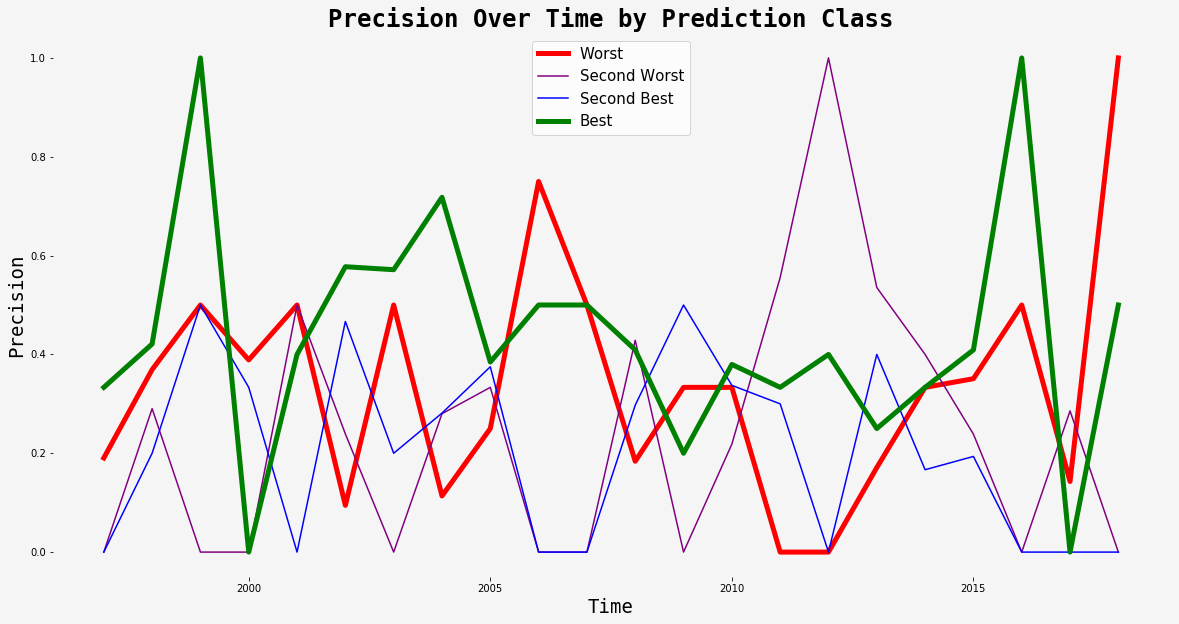

In [31]:
ax = plt.gca()
fig = plt.gcf()


plt.plot(years,prec[0],color='red',linewidth=5, label = "Worst")
plt.plot(years,prec[1],color='purple', label = "Second Worst")
plt.plot(years,prec[2],color='blue', label = "Second Best")
plt.plot(years,prec[3],color='green',linewidth=5, label = "Best")


fig.set_facecolor('whitesmoke')
ax.set_facecolor('whitesmoke')
plt.legend(prop={'size': 15})
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Precision", fontsize=16)
ax.set_title("Class Precision Over Time", fontsize=24, weight = 'bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.rcParams['figure.figsize'] = [20,10]
plt.xlabel('Time',fontsize=19,family='monospace')
plt.ylabel('Precision',fontsize=19,family='monospace')
plt.title('Precision Over Time by Prediction Class',fontsize=24,weight='bold',family='monospace')
plt.show()

In [18]:
mainStockFrame[["Quarter end{}".format(i) for i in range(1,9)]]

,Quarter end1,Quarter end2,Quarter end3,Quarter end4,Quarter end5,Quarter end6,Quarter end7,Quarter end8
0,2015-09-30,2015-12-31,2016-03-31,2016-06-30,2016-09-30,2017-03-31,2017-06-30,2018-12-31
1,2013-09-30,2013-12-31,2014-03-31,2014-06-30,2014-09-30,2014-12-31,2015-03-31,2015-06-30
2,2010-03-31,2010-06-30,2010-09-30,2010-12-31,2011-03-31,2011-06-30,2011-09-30,2012-12-31
3,2008-03-31,2008-06-30,2008-09-30,2008-12-31,2009-03-31,2009-06-30,2009-09-30,2009-12-31
4,2004-09-30,2004-12-31,2005-03-31,2005-06-30,2005-09-30,2006-03-31,2006-06-30,2007-12-31
5,2002-09-30,2002-12-31,2003-03-31,2003-06-30,2003-09-30,2003-12-31,2004-03-31,2004-06-30
6,1998-12-31,1999-03-31,1999-06-30,1999-09-30,1999-12-31,2000-03-31,2000-06-30,2001-12-31
7,1996-12-31,1997-03-31,1997-06-30,1997-09-30,1997-12-31,1998-03-31,1998-06-30,1998-09-30
8,1993-09-30,1993-12-31,1994-03-31,1994-06-30,1994-09-30,1995-03-31,1995-06-30,1996-09-30
9,2015-09-30,2015-12-31,2016-03-31,2016-06-30,2016-09-30,2017-03-31,2017-06-30,2018-12-31
